# Предобработка данных

In [1]:
# Установка библиотек
import numpy as np
import pandas as pd
import sys
import os
from dotenv import load_dotenv
# sys.path.append("./utils")
# from params import dict_hh, list_skills
from utils import dict_hh, list_skills
import json
import requests
import time
import re
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Загрузка данных, df_hh - данные с HH.ru, df_sj - данные c SuperJOB
df_hh = pd.read_csv('C:\\Users\\velvi\\Marta\\ITMO\\projects\\graduate work\\HH.csv')
df_sj = pd.read_csv('C:\\Users\\velvi\\Marta\\ITMO\\projects\\graduate work\\SuperJOB.csv')

In [4]:
df_hh.head(2)

,сайт,айди специальности,специальность,название вакансии,компания,ссылка,ключевые навыки,описание,зарплата от,зарплата до,валюта,опыт,график,образование,город,дата публикации
0,hh.ru,96,"Программист, разработчик",Frontend-разработчик,Кирилин Алексей Вадимович,https://hh.ru/vacancy/120089865,JavaScript,<p><strong>О компании:</strong></p> <p>Мы — ко...,NaN,100000.0,RUR,Нет опыта,Полный день,NaN,Москва,2025-04-30T01:21:23+0300
1,hh.ru,96,"Программист, разработчик",Java-разработчик (junior),DigitalBudget,https://hh.ru/vacancy/120100785,"Java, ООП, PostgreSQL, Spring Framework","<p>Мы — <strong>Digital Budget</strong>, компа...",40000.0,NaN,RUR,Нет опыта,Полный день,NaN,Брянск,2025-04-30T09:43:09+0300


In [5]:
df_sj.head(2)

,сайт,id,ссылка,компания,категория,айди специальности,специальность,название,описание,зарплата от,зарплата до,валюта,опыт,график,образование,город,дата публикации
0,superjob,50134568,https://www.superjob.ru/vacancy/50134568,Дом Моды HENDERSON,Разработчики,48,"Программист, разработчик",Программист-разработчик 1С,"<p><b>Обязанности:</b></p><ul><li>Внедрение, а...",0,0,rub,От 1 года,Полный рабочий день,Не имеет значения,Химки,2025-05-05
1,superjob,50362238,https://www.superjob.ru/vacancy/50362238,"ГКУ МО ""Централизованная бухгалтерия Московско...",Разработчики,48,"Программист, разработчик",Руководитель группы разработчиков 1С,<p><b>Обязанности:</b></p><ul><li>Управление к...,300000,380000,rub,От 1 года,Полный рабочий день,Высшее,Москва,2025-05-05


In [3]:
'''Изменяем словарь который использовался при получении данные с API
(при получении новых данных с API необходимо пропустить этот шаг, так как словарь в params.py корректный)'''

rename_col = {
    item["id"]: item["name"]
    for renam in dict_hh.values()
    for item in renam
}
# Актуализация значения
df_hh["специальность"] = df_hh["айди специальности"].map(rename_col)

In [4]:
# Создание новой колонки и заполнение значением категории по id согласно словарю dict_hh
df_hh['profession_category'] = [next(category for category, value in dict_hh.items() 
                                      for id_dict in value if id_dict['id'] == id_df ) for id_df in df_hh['айди специальности']]

In [6]:
# Создаем словари, для переименования имени колонок и список для упорядоченного расположения колонок
dict_rename_col_sj = {'сайт': 'website', 'город': 'city', 'категория': 'profession_category', 'специальность': 'specialization', 'название': 'job_title', 'описание': 'description', 'профессиональные навыки': 'skills',
                   'график': 'work_schedule', 'опыт': 'experience','образование': 'education', 'зарплата от': 'salary_from', 'зарплата до': 'salary_up', 'валюта': 'currency', 
                   'компания': 'company', 'дата публикации': 'date_of_publication', 'ссылка': 'link'}
dict_rename_col_hh = {'сайт': 'website', 'город': 'city', 'категория': 'profession_category', 'специальность': 'specialization', 'название вакансии': 'job_title', 'описание': 'description', 'ключевые навыки': 'skills',
                   'график': 'work_schedule', 'опыт': 'experience','образование': 'education', 'зарплата от': 'salary_from', 'зарплата до': 'salary_up', 'валюта': 'currency', 
                   'компания': 'company', 'дата публикации': 'date_of_publication', 'ссылка': 'link'}
list_rename = ['website', 'city', 'profession_category', 'specialization', 'job_title', 'description', 'skills', 'work_schedule', 'experience', 'education', 'salary_from', 'salary_up',
               'currency', 'company', 'date_of_publication', 'link']

In [7]:
# Изменения названий колонок
df_sj = df_sj.rename(columns=dict_rename_col_sj)
df_hh = df_hh.rename(columns=dict_rename_col_hh)

# Удаляем лишние колонки
df_hh = df_hh.drop(columns=['айди специальности'])
df_sj = df_sj.drop(columns=['id'])

In [8]:
# Объединяем DataFrame
df_vacancy = pd.concat([df_sj, df_hh]).reset_index(drop=True)

# Меняем расположение колонок
df_vacancy = df_vacancy[list_rename]

In [11]:
df_vacancy.head(3)

,website,city,profession_category,specialization,job_title,description,skills,work_schedule,experience,education,salary_from,salary_up,currency,company,date_of_publication,link
0,superjob,Химки,Разработчики,"Программист, разработчик",Программист-разработчик 1С,"<p><b>Обязанности:</b></p><ul><li>Внедрение, а...",NaN,Полный рабочий день,От 1 года,Не имеет значения,0.0,0.0,rub,Дом Моды HENDERSON,2025-05-05,https://www.superjob.ru/vacancy/50134568
1,superjob,Москва,Разработчики,"Программист, разработчик",Руководитель группы разработчиков 1С,<p><b>Обязанности:</b></p><ul><li>Управление к...,NaN,Полный рабочий день,От 1 года,Высшее,300000.0,380000.0,rub,"ГКУ МО ""Централизованная бухгалтерия Московско...",2025-05-05,https://www.superjob.ru/vacancy/50362238
2,superjob,Сергиев Посад,Разработчики,"Программист, разработчик",Инженер-технолог-программист (металлообработка...,<b>Обязанности:</b><p>- Технологическая подгот...,NaN,Сменный график работы,От 3 лет,Высшее,120000.0,0.0,rub,МЕТТОЙЛ,2025-05-05,https://www.superjob.ru/vacancy/30945389


In [12]:
df_vacancy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9631 entries, 0 to 9630
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   website              9631 non-null   object 
 1   city                 9631 non-null   object 
 2   profession_category  9631 non-null   object 
 3   specialization       9631 non-null   object 
 4   job_title            9631 non-null   object 
 5   description          9631 non-null   object 
 6   skills               3321 non-null   object 
 7   work_schedule        9631 non-null   object 
 8   experience           9631 non-null   object 
 9   education            3863 non-null   object 
 10  salary_from          6257 non-null   float64
 11  salary_up            5374 non-null   float64
 12  currency             6583 non-null   object 
 13  company              9631 non-null   object 
 14  date_of_publication  9631 non-null   object 
 15  link                 9631 non-null   o

In [9]:
# Приводим к единому формату и типу datetime64[ns]
df_vacancy['date_of_publication'] = pd.to_datetime(df_vacancy['date_of_publication'].str[:10])

# Преобразуем по городам, удаляем скобки, области РФ и пробелы
df_vacancy['city'] = df_vacancy['city'].str.split('(').str[0].str.strip()

In [ ]:
# Запрос на получение информации по субъектам РФ, географической широты и долготы через сервес API Yandex geocoder
load_dotenv()
API_KEY = os.getenv('API_KEY')

# Передаем только уникальные значения (города)
unique_cities = df_vacancy['city'].unique()

# Словарь для хранения полного ответа по каждому городу
full_geo_yandex = {}

 # Функция для запроса
def requests_yandex_geo(city_name):
    params = {
        'apikey': API_KEY,
        'geocode': city_name,
        'format': 'json',
        'lang': 'ru_RU',
        'results': 1
    }
    try:
        response = requests.get('https://geocode-maps.yandex.ru/1.x/', params=params, timeout=10)
        return response.json()
    except Exception as e:
        print(f'Ошибка при запросе города "{city_name}": {e}')
        return None

# Перебор по городам
for city in unique_cities:
    data = requests_yandex_geo(city)
    full_geo_yandex[city] = data
    time.sleep(1)  # Пауза

# Сохраняем результат в JSON-файл
with open('full_geo_yandex.json', 'w', encoding='utf-8') as f:
    json.dump(full_geo_yandex, f, ensure_ascii=False, indent=4)

print("Данные сохранены в full_geo_yandex.json")

# # Проверка сколько городов получило ответ
# original_cities = set(df_vacancy['city'].unique())
# queried_cities = set(full_geo_yandex.keys()
# missing_cities = original_cities - queried_cities
# print(len(missing_cities))

In [10]:
# Читаем файл с даными полученными от API Yandex geocoder
with open('C:\\Users\\velvi\\Marta\\ITMO\\projects\\graduate work\\full_geo_yandex.json', 'r', encoding='utf-8') as f:
  full_geo_yandex = json.load(f)

In [11]:
# Создаем словарь для извлечения данных, город : [субъект РФ, широта, долгота]
city_info = {}

# Функция для извлечения данных
for city_name, city_data in full_geo_yandex.items():
    try:
        # Достаем гео-запись
        geo = city_data['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']

        # Извлекаем субъект РФ из строки 'formatted'
        address = geo['metaDataProperty']['GeocoderMetaData']['Address']['formatted']
        parts = address.split(',')
        subject_rf = parts[1].strip()

        # 2. Извлекаем координаты
        lon, lat = geo['Point']['pos'].split()
        lat, lon = float(lat), float(lon)  # Преобразуем в float

        # 3. Записываем в словарь
        city_info[city_name] = [subject_rf, lat, lon]

    except Exception as e:
        print(f"Ошибка для города {city_name}: {e}")
        city_info[city_name] = [None, None, None]

Ошибка для города Кипр: list index out of range


In [12]:
# Создаем новые колонки в DataFrame, присваиваем им значения из словаря  
df_vacancy['subjects_RF'] = df_vacancy['city'].map(lambda x: city_info.get(x, [None, None, None])[0]) # None значение по умолчанию, чтобы не упасть с ошибкой
df_vacancy['city_latitude'] = df_vacancy['city'].map(lambda x: city_info.get(x)[1])
df_vacancy['city_longitude'] = df_vacancy['city'].map(lambda x: city_info.get(x)[2])

In [13]:
# Преобразуем значения в колонке "skills"
df_vacancy['skills'] = df_vacancy['skills'].apply(
    lambda x: ', '.join(set(s.strip() for s in str(x).lower().split(','))) if pd.notna(x) else x)


In [14]:
# Для пополнения остутвующих значений в колонке "skills", извлекаем данные из description, для этого есть подготовленый список list_skills с ключевыми навыками
# Создаем маску где skills == NaN
mask = df_vacancy['skills'].isna()

# Выбираем "description" в строках где нет "skills"
descriptions = df_vacancy.loc[mask, 'description']

# re.escape чтобы спец. символы не портили поиск (добавим перед спец симв \ т.е. экранируем спецсимволы), объединяем навыки через (или)
skill_pattern = '|'.join([re.escape(i) for i in list_skills])

''' str.findall() находит все соответствия шаблону в каждой строке ({skill_pattern}) - подставляет созданный ранее шаблон навыков.
(?i) - флаг для case-insensitive поиска (не учитывает регистр) \b - границы слова (чтобы искать целые слова, а не части слов)'''
matched = (descriptions.str.findall(rf'(?i)\b({skill_pattern})\b')).apply(lambda x: list(set(skill.lower() for skill in x)))

# Добавление навыков для строк с NaN
df_vacancy.loc[mask, 'skills'] = matched.apply(lambda x: ', '.join(set(x)) if x else np.nan)

In [15]:
# Удаляем строку которая отсутвует в колонке, там всего одна и это Кипр
df_vacancy = df_vacancy.dropna(subset=['subjects_RF'])

# Преобразуем зарплату от в Int64 с сохранением NaN
df_vacancy[['salary_from','salary_up']] = df_vacancy[['salary_from','salary_up']].astype('Int64')

# Преобразуем данные
df_vacancy['currency'] = df_vacancy['currency'].str.lower().replace('rur', 'rub')

# Функция для пересчета в рубли по курсу (кур usd 80,89 eur 90,11)
def currency(cur):
    if cur['currency'] == 'usd':
        return round(cur['salary_from'] * 80.89) if pd.notna(cur['salary_from']) else np.nan
    elif cur['currency'] == 'eur':
        return round(cur['salary_from'] * 90.11) if pd.notna(cur['salary_from']) else np.nan
    return cur['salary_from']  # Если рубли или NaN, оставляем как есть

# Забираем построчно данные, для перерасчета. 
df_vacancy['salary_from'] = df_vacancy.apply(currency, axis=1)

# Приводим к нижнему регистру и перезаписываем значения
df_vacancy['currency'] = df_vacancy['currency'].str.lower().replace({'usd': 'rub', 'eur': 'rub'})
df_vacancy['salary_from'] = df_vacancy['salary_from'].astype('Int64')

# Удаляем колонку, так как мы все в рубли перевели
df_vacancy = df_vacancy.drop(columns=['currency'])

In [16]:
# Проверяем на полные дубликаты, удаляем дубли
df_vacancy[df_vacancy.duplicated(keep=False)]
df_vacancy.drop_duplicates(keep='first', inplace=True)

# Присваиваем новые идексы перезаписываем на месте
df_vacancy.reset_index(drop=True, inplace=True)

In [22]:
df_vacancy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7626 entries, 0 to 7625
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   website              7626 non-null   object        
 1   city                 7626 non-null   object        
 2   profession_category  7626 non-null   object        
 3   specialization       7626 non-null   object        
 4   job_title            7626 non-null   object        
 5   description          7626 non-null   object        
 6   skills               6227 non-null   object        
 7   work_schedule        7626 non-null   object        
 8   experience           7626 non-null   object        
 9   education            1859 non-null   object        
 10  salary_from          4253 non-null   Int64         
 11  salary_up            3370 non-null   Int64         
 12  company              7626 non-null   object        
 13  date_of_publication  7626 non-nul

In [23]:
df_vacancy['education'].unique()

array(['Не имеет значения', 'Высшее', 'Среднее специальное',
       'Неполное высшее', 'Среднее', nan], dtype=object)

In [17]:
# Заменим NaN на "не имеет значения"
df_vacancy['education'] = df_vacancy['education'].fillna('не имеет значения').str.lower()

# Встречается 0 в значениях, заменим его на NaN
df_vacancy['salary_from'] = df_vacancy['salary_from'].replace(0, np.nan)

In [18]:
'''В колонке "salary_from" встречается 0 при этом в колонке "salary up" в тех же строках указана зарплата до 
(отнимем 30% от "salary_up" и подставим результат в "salary_from", для заполнения NaN)'''

df_vacancy['salary_from'] = df_vacancy.apply(
    lambda i: round(i['salary_up'] * 0.7) if (pd.isna(i['salary_from']) or i['salary_from'] == 0) and pd.notna(i['salary_up']) and i['salary_up'] > 0
    else i['salary_from'],axis=1).astype('Int64')

In [26]:
df_vacancy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7626 entries, 0 to 7625
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   website              7626 non-null   object        
 1   city                 7626 non-null   object        
 2   profession_category  7626 non-null   object        
 3   specialization       7626 non-null   object        
 4   job_title            7626 non-null   object        
 5   description          7626 non-null   object        
 6   skills               6227 non-null   object        
 7   work_schedule        7626 non-null   object        
 8   experience           7626 non-null   object        
 9   education            7626 non-null   object        
 10  salary_from          4308 non-null   Int64         
 11  salary_up            3370 non-null   Int64         
 12  company              7626 non-null   object        
 13  date_of_publication  7626 non-nul

In [27]:
# Минимальное значение заработной платы
df_vacancy[df_vacancy['salary_from'].notna()].sort_values(by='salary_from', ascending=True).head(5)[['job_title', 'company', 'city', 'salary_from']]

,job_title,company,city,salary_from
3004,Системный администратор,ГБУДО ЦРТ,Санкт-Петербург,40
2995,Системный администратор,Министерство Цифрового Развития и Связи Хабаро...,Хабаровск,50
1911,Java-разработчик,Innovasystem,Москва,180
7447,Специалист / Технический писатель,Аэроб,Москва,200
3023,Системный администратор / IT-стажер,MSTech L.L.C-FZ,Москва,455


In [19]:
# Есть неверно обозначенные данные заработных плат, приводим в соответствие
def correct_salary(salary):
    if pd.isna(salary):
        return salary  # если значение пропущено, возвращаем как есть
    num_digits = len(str(int(salary)))  # считаем количество цифр
    if num_digits == 2:
        return salary * 1000
    elif num_digits == 3:
        return salary * 100
    elif num_digits == 4:
        return salary * 10
    else:
        return salary  # 5 и более цифр оставляем как есть

df_vacancy['salary_from'] = df_vacancy['salary_from'].apply(correct_salary).astype('Int64')

In [29]:
len(df_vacancy[df_vacancy['salary_up'] == 0])

968

In [29]:
df_vacancy['work_schedule'] = df_vacancy['work_schedule'].replace({'полный день': 'полный рабочий день', 'сменный график': 'сменный график работы'})

In [20]:
'''Так как нам колонка "salary_up" поможет для обучения модели ML, преобразуем ее 
(заменин 0 на NaN, если в строке заполнено значения колонки "salary_from" присвоим это же значение "salary_up")'''

df_vacancy['salary_up'] = df_vacancy['salary_up'].replace(0, np.nan)
df_vacancy['salary_up'] = df_vacancy.apply(
    lambda i: i['salary_from'] if pd.isna(i['salary_up']) and pd.notna(i['salary_from']) else i['salary_up'],
    axis=1
).astype('Int64')
df_vacancy['salary_up'] = df_vacancy['salary_up'].apply(correct_salary).astype('Int64')


In [31]:
df_vacancy.describe()

,salary_from,salary_up,date_of_publication,city_latitude,city_longitude
count,4308.0,4308.0,7626,7626.000000,7626.000000
mean,117378.568942,368036.401578,2025-04-24 18:01:36.302124288,55.503586,44.401898
min,10000.0,10000.0,2025-04-03 00:00:00,42.115189,-171.701208
25%,63000.0,75000.0,2025-04-18 00:00:00,55.755864,37.617698
50%,98000.0,110000.0,2025-04-28 00:00:00,55.755864,37.617698
75%,140000.0,150000.0,2025-05-01 00:00:00,55.991893,40.926894
max,1000000.0,999999999.0,2025-05-05 00:00:00,71.980467,158.643503
std,82373.768997,15233933.319508,NaN,3.490351,20.072342


In [21]:
# Корректируем колонки
df_vacancy['experience'] = df_vacancy['experience'].str.lower().replace({'не имеет значения': 'без опыта', 'нет опыта': 'без опыта',
 'от 1 года до 3 лет': 'от 1 года', 'от 3 до 6 лет': 'от 3 лет', 'более 6 лет': 'от 6 лет'})

df_vacancy['work_schedule'] = df_vacancy['work_schedule'].str.lower().replace('работа вахтовым методом', 'вахтовый метод')

In [22]:
list_rename = ['website', 'city', 'subjects_RF', 'city_latitude', 'city_longitude', 'profession_category', 'specialization', 'job_title', 'description', 'skills', 'work_schedule', 'experience', 'education', 'salary_from', 'salary_up',
                 'company', 'date_of_publication', 'link']
df_vacancy = df_vacancy[list_rename]

In [34]:
df_vacancy

,website,city,subjects_RF,city_latitude,city_longitude,profession_category,specialization,job_title,description,skills,work_schedule,experience,education,salary_from,salary_up,company,date_of_publication,link
0,superjob,Химки,Московская область,55.889361,37.444853,Разработчики,"Программист, разработчик",Программист-разработчик 1С,"<p><b>Обязанности:</b></p><ul><li>Внедрение, а...","sql, программирование",полный рабочий день,от 1 года,не имеет значения,<NA>,<NA>,Дом Моды HENDERSON,2025-05-05,https://www.superjob.ru/vacancy/50134568
1,superjob,Москва,Москва,55.755864,37.617698,Разработчики,"Программист, разработчик",Руководитель группы разработчиков 1С,<p><b>Обязанности:</b></p><ul><li>Управление к...,"git, soap, agile, sql, rest, scrum, аналитичес...",полный рабочий день,от 1 года,высшее,300000,380000,"ГКУ МО ""Централизованная бухгалтерия Московско...",2025-05-05,https://www.superjob.ru/vacancy/50362238
2,superjob,Сергиев Посад,Московская область,56.315311,38.135972,Разработчики,"Программист, разработчик",Инженер-технолог-программист (металлообработка...,<b>Обязанности:</b><p>- Технологическая подгот...,NaN,сменный график работы,от 3 лет,высшее,120000,120000,МЕТТОЙЛ,2025-05-05,https://www.superjob.ru/vacancy/30945389
3,superjob,Москва,Москва,55.755864,37.617698,Разработчики,"Программист, разработчик","Разработчик автохимии, лакокрасочных материалов",<p><b>Обязанности:</b><br />Требуется разработ...,NaN,неполный рабочий день,от 6 лет,высшее,70000,90000,ГК ПРОМТЕХ,2025-05-05,https://www.superjob.ru/vacancy/27748567
4,superjob,Хабаровск,Хабаровск,48.480229,135.071917,Разработчики,"Программист, разработчик",Ведущий программист 1С (ХА),<b>Обязанности:</b><ul><li>Администрирование\n...,"стрессоустойчивость, 1с, коммуникабельность",полный рабочий день,от 1 года,не имеет значения,103180,103180,Хабаровский аэропорт,2025-05-04,https://www.superjob.ru/vacancy/41502773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7621,hh.ru,Москва,Москва,55.755864,37.617698,Прочие,Технический писатель,Технический писатель (Тераплан),<p><strong>Тераплан</strong> — это платформа д...,разработка технической документации,удаленная работа,от 1 года,не имеет значения,<NA>,<NA>,YADRO,2025-04-05,https://hh.ru/vacancy/119190416
7622,hh.ru,Краснодар,Краснодар,45.035470,38.975313,Прочие,Технический писатель,Технический писатель (1С),<p><strong>Обязанности:</strong></p> <ul> <li>...,"powerpoint, excel, visio, word",удаленная работа,от 1 года,не имеет значения,<NA>,<NA>,ИК СИБИНТЕК,2025-04-14,https://hh.ru/vacancy/113041936
7623,hh.ru,Санкт-Петербург,Санкт-Петербург,59.938784,30.314997,Прочие,Технический писатель,Технический писатель,<p><strong>Обязанности:</strong></p> <ul> <li>...,NaN,полный день,от 1 года,не имеет значения,<NA>,<NA>,PERCo,2025-04-28,https://hh.ru/vacancy/118721989
7624,hh.ru,Санкт-Петербург,Санкт-Петербург,59.938784,30.314997,Прочие,Технический писатель,Начинающий специалист по разработке техническо...,<p><strong>Компания ООО &quot;НПП &quot;Адвент...,"powerpoint, excel, visio, word",полный день,без опыта,не имеет значения,50000,50000,Адвент НПП,2025-04-25,https://hh.ru/vacancy/119968837


In [35]:
''' Для заполнения отсутвующих значений в "salary_from", для начала нужно заполним NaN в "salary_up" с помощью модели машинного обучения'''

# Подготовка данных 
df_up = df_vacancy.copy()
df_up = df_up.dropna(subset=['city_latitude', 'city_longitude', 'city', 'profession_category', 'specialization',
                       'experience', 'work_schedule', 'education', 'salary_up', 'subjects_RF', 'job_title', 'company'])

# Удалим выбросы (1-й и 99-й перцентили)
q_low = df_up['salary_up'].quantile(0.01)
q_high = df_up['salary_up'].quantile(0.99)
df_up = df_up[(df_up['salary_up'] >= q_low) & (df_up['salary_up'] <= q_high)]

# Делим на Х и У
y = df_up['salary_up']
X = df_up.drop(columns=['salary_up'])

# Делим по типу данных категориальные и числовые (для упрощения обработки)
cat_features_up = ['city', 'profession_category', 'specialization',
                      'experience', 'work_schedule', 'education', 'subjects_RF', 'job_title', 'company']
num_features_up = ['city_latitude', 'city_longitude']

cat_data_up = X[cat_features_up]
num_data_up = X[num_features_up]

# Делим данные для обучения и теста
X_cat_train, X_cat_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    cat_data_up, num_data_up, y, test_size=0.2, random_state=3)

# Объединение (CatBoost принимает единую матрицу признаков)
X_train_full = pd.concat([X_num_train, X_cat_train], axis=1)
X_test_full = pd.concat([X_num_test, X_cat_test], axis=1)

'''Получаем индексы столбцов с категориальными признаками np.arange создает последовательность чисел,
len(num_features_names) - количество числовых признаков
X_train_full.shape[1] - общее количество признаков'''

cat_feature_indices = np.arange(len(num_features_up), X_train_full.shape[1])

# Pool формат данных для CatBoost, data - признаки, label - целевая переменная, cat_features - индексы категориальных признаков
train_pool = Pool(data=X_train_full, label=y_train, cat_features=cat_feature_indices)
test_pool = Pool(data=X_test_full, cat_features=cat_feature_indices)

# Модель + Grid Search
model_up = CatBoostRegressor(loss_function='RMSE', verbose=0)

grid = {
    'depth': [6, 8],
    'iterations': [500, 800,],
    'learning_rate': [0.1]
}

grid_search_result_up = model_up.grid_search(grid, X=train_pool, cv=5, plot=False)

# Обучаем и тестируем
y_pred_train = model_up.predict(X_train_full)
y_pred_test = model_up.predict(X_test_full)

# R² (коэффициент детерминации)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# RMSE (среднеквадратическая ошибка)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Вывод
print(f'R² на обучающей выборке: {r2_train:.4f}')
print(f'R² на тестовой выборке: {r2_test:.4f}')
print(f'RMSE на обучающей выборке: {rmse_train:.2f}')
print(f'RMSE на тестовой выборке: {rmse_test:.2f}')

# Смотрим лучшие гиперпараметры
best_params = grid_search_result_up['params']
best_params


bestTest = 60508.19083
bestIteration = 95

0:	loss: 60508.1908277	best: 60508.1908277 (0)	total: 13.6s	remaining: 40.9s

bestTest = 60508.19083
bestIteration = 95

1:	loss: 60508.1908277	best: 60508.1908277 (0)	total: 33.2s	remaining: 33.2s

bestTest = 60539.59972
bestIteration = 94

2:	loss: 60539.5997162	best: 60508.1908277 (0)	total: 52s	remaining: 17.3s

bestTest = 60539.59972
bestIteration = 94

3:	loss: 60539.5997162	best: 60508.1908277 (0)	total: 1m 22s	remaining: 0us
Estimating final quality...
Training on fold [0/5]

bestTest = 53823.99264
bestIteration = 238

Training on fold [1/5]

bestTest = 60649.45167
bestIteration = 119

Training on fold [2/5]

bestTest = 58608.68644
bestIteration = 199

Training on fold [3/5]

bestTest = 52287.07077
bestIteration = 272

Training on fold [4/5]

bestTest = 59796.60572
bestIteration = 293

R² на обучающей выборке: 0.6463
R² на тестовой выборке: 0.5835
RMSE на обучающей выборке: 50211.14
RMSE на тестовой выборке: 59400.81


{'depth': 6, 'learning_rate': 0.1, 'iterations': 500}

In [36]:
'''Применение модели ML "model_up" на DataFrame'''

# Отбираем строки, где salary_up отсутствует, но другие признаки есть (по которым была обучена модель)
df_up_to_fill = df_vacancy[df_vacancy['salary_up'].isna()].copy()

# Формируем X как при обучении
X_fill_cat = df_up_to_fill[cat_features_up]
X_fill_num = df_up_to_fill[num_features_up]
X_fill_full = pd.concat([X_fill_num, X_fill_cat], axis=1)

# Предсказываем
predicted_salary_up = model_up.predict(X_fill_full)

# Применяем предсказанное в DataFrame (округляем и переводим в Int64)
df_vacancy.loc[df_up_to_fill.index, 'salary_up'] = pd.Series(predicted_salary_up, index=df_up_to_fill.index).round().astype('Int64')
print(f"Осталось пропусков в salary_up: {df_vacancy['salary_up'].isna().sum()}")


Осталось пропусков в salary_up: 0


In [38]:
# Обучение модели ML, для заполнения колонки "salary_from"
df = df_vacancy.copy()
df = df.dropna(subset=['salary_from', 'city', 'profession_category', 'specialization',
                       'experience', 'work_schedule', 'education', 'salary_up', 'subjects_RF'])

q_low = df['salary_from'].quantile(0.01)
q_high = df['salary_from'].quantile(0.99)
df = df[(df['salary_from'] >= q_low) & (df['salary_from'] <= q_high)]

y = df['salary_from']
X = df.drop(columns=['salary_from'])

cat_features_names = ['city', 'profession_category', 'specialization',
                      'experience', 'work_schedule', 'education', 'subjects_RF']
num_features_names = ['salary_up']

cat_data = X[cat_features_names]
num_data = X[num_features_names]

X_cat_train, X_cat_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    cat_data, num_data, y, test_size=0.2, random_state=42)

X_train_full = pd.concat([X_num_train, X_cat_train], axis=1)
X_test_full = pd.concat([X_num_test, X_cat_test], axis=1)

cat_feature_indices = np.arange(len(num_features_names), X_train_full.shape[1])

train_pool = Pool(data=X_train_full, label=y_train, cat_features=cat_feature_indices)
test_pool = Pool(data=X_test_full, cat_features=cat_feature_indices)

model = CatBoostRegressor(loss_function='RMSE', verbose=0)

grid = {
    'depth': [6, 8],
    'iterations': [500, 700],
    'learning_rate': [0.1]
}

grid_search_result = model.grid_search(grid, X=train_pool, cv=3, plot=False)

y_pred_train = model.predict(X_train_full)
y_pred_test = model.predict(X_test_full)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f'R² на обучающей выборке: {r2_train:.4f}')
print(f'R² на тестовой выборке: {r2_test:.4f}')
print(f'RMSE на обучающей выборке: {rmse_train:.2f}')
print(f'RMSE на тестовой выборке: {rmse_test:.2f}')

best_params = grid_search_result['params']
best_params


bestTest = 27181.36389
bestIteration = 394

0:	loss: 27181.3638904	best: 27181.3638904 (0)	total: 10.2s	remaining: 30.5s

bestTest = 27181.36389
bestIteration = 394

1:	loss: 27181.3638904	best: 27181.3638904 (0)	total: 24.6s	remaining: 24.6s

bestTest = 27678.19037
bestIteration = 258

2:	loss: 27678.1903693	best: 27181.3638904 (0)	total: 40.2s	remaining: 13.4s

bestTest = 27678.19037
bestIteration = 258

3:	loss: 27678.1903693	best: 27181.3638904 (0)	total: 1m 1s	remaining: 0us
Estimating final quality...
Training on fold [0/3]

bestTest = 28396.27159
bestIteration = 179

Training on fold [1/3]

bestTest = 24353.59834
bestIteration = 142

Training on fold [2/3]

bestTest = 27259.2901
bestIteration = 174

R² на обучающей выборке: 0.9142
R² на тестовой выборке: 0.8703
RMSE на обучающей выборке: 21746.65
RMSE на тестовой выборке: 25901.74


{'depth': 6, 'learning_rate': 0.1, 'iterations': 500}

In [39]:
# Применяем модели ML "model" на DataFrame
df_from_to_fill = df_vacancy[df_vacancy['salary_from'].isna()].copy()

X_from_cat = df_from_to_fill[cat_features_names]
X_from_num = df_from_to_fill[num_features_names]
X_from_full = pd.concat([X_from_num, X_from_cat], axis=1)

predicted_salary_from = model.predict(X_from_full)

df_vacancy.loc[df_from_to_fill.index, 'salary_from'] = pd.Series(predicted_salary_from, index=df_from_to_fill.index).round().astype('Int64')

print(f"Осталось пропусков в salary_from: {df_vacancy['salary_from'].isna().sum()}")


Осталось пропусков в salary_from: 0


In [40]:
df_vacancy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7626 entries, 0 to 7625
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   website              7626 non-null   object        
 1   city                 7626 non-null   object        
 2   subjects_RF          7626 non-null   object        
 3   city_latitude        7626 non-null   float64       
 4   city_longitude       7626 non-null   float64       
 5   profession_category  7626 non-null   object        
 6   specialization       7626 non-null   object        
 7   job_title            7626 non-null   object        
 8   description          7626 non-null   object        
 9   skills               6227 non-null   object        
 10  work_schedule        7626 non-null   object        
 11  experience           7626 non-null   object        
 12  education            7626 non-null   object        
 13  salary_from          7626 non-nul

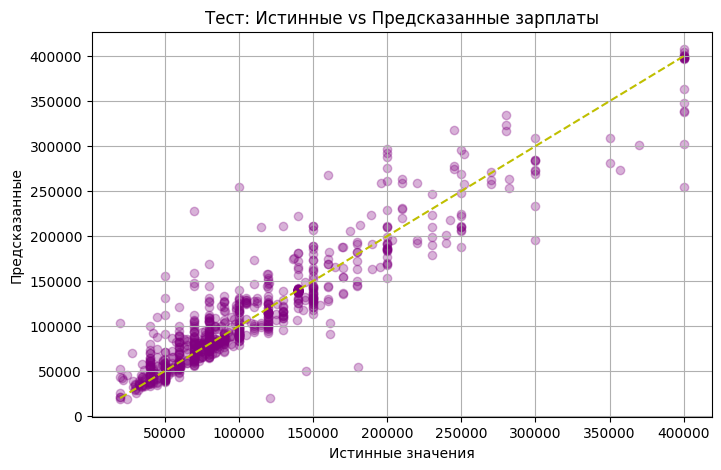

In [41]:
# Визуализация предсказаний ML
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_test, alpha=0.3, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--y')
plt.title('Тест: Истинные vs Предсказанные зарплаты')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные')
plt.grid(True)


In [42]:
df_vacancy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7626 entries, 0 to 7625
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   website              7626 non-null   object        
 1   city                 7626 non-null   object        
 2   subjects_RF          7626 non-null   object        
 3   city_latitude        7626 non-null   float64       
 4   city_longitude       7626 non-null   float64       
 5   profession_category  7626 non-null   object        
 6   specialization       7626 non-null   object        
 7   job_title            7626 non-null   object        
 8   description          7626 non-null   object        
 9   skills               6227 non-null   object        
 10  work_schedule        7626 non-null   object        
 11  experience           7626 non-null   object        
 12  education            7626 non-null   object        
 13  salary_from          7626 non-nul

In [43]:
df_vacancy

,website,city,subjects_RF,city_latitude,city_longitude,profession_category,specialization,job_title,description,skills,work_schedule,experience,education,salary_from,salary_up,company,date_of_publication,link
0,superjob,Химки,Московская область,55.889361,37.444853,Разработчики,"Программист, разработчик",Программист-разработчик 1С,"<p><b>Обязанности:</b></p><ul><li>Внедрение, а...","sql, программирование",полный рабочий день,от 1 года,не имеет значения,96257,102999,Дом Моды HENDERSON,2025-05-05,https://www.superjob.ru/vacancy/50134568
1,superjob,Москва,Москва,55.755864,37.617698,Разработчики,"Программист, разработчик",Руководитель группы разработчиков 1С,<p><b>Обязанности:</b></p><ul><li>Управление к...,"git, soap, agile, sql, rest, scrum, аналитичес...",полный рабочий день,от 1 года,высшее,300000,380000,"ГКУ МО ""Централизованная бухгалтерия Московско...",2025-05-05,https://www.superjob.ru/vacancy/50362238
2,superjob,Сергиев Посад,Московская область,56.315311,38.135972,Разработчики,"Программист, разработчик",Инженер-технолог-программист (металлообработка...,<b>Обязанности:</b><p>- Технологическая подгот...,NaN,сменный график работы,от 3 лет,высшее,120000,120000,МЕТТОЙЛ,2025-05-05,https://www.superjob.ru/vacancy/30945389
3,superjob,Москва,Москва,55.755864,37.617698,Разработчики,"Программист, разработчик","Разработчик автохимии, лакокрасочных материалов",<p><b>Обязанности:</b><br />Требуется разработ...,NaN,неполный рабочий день,от 6 лет,высшее,70000,90000,ГК ПРОМТЕХ,2025-05-05,https://www.superjob.ru/vacancy/27748567
4,superjob,Хабаровск,Хабаровск,48.480229,135.071917,Разработчики,"Программист, разработчик",Ведущий программист 1С (ХА),<b>Обязанности:</b><ul><li>Администрирование\n...,"стрессоустойчивость, 1с, коммуникабельность",полный рабочий день,от 1 года,не имеет значения,103180,103180,Хабаровский аэропорт,2025-05-04,https://www.superjob.ru/vacancy/41502773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7621,hh.ru,Москва,Москва,55.755864,37.617698,Прочие,Технический писатель,Технический писатель (Тераплан),<p><strong>Тераплан</strong> — это платформа д...,разработка технической документации,удаленная работа,от 1 года,не имеет значения,83940,110512,YADRO,2025-04-05,https://hh.ru/vacancy/119190416
7622,hh.ru,Краснодар,Краснодар,45.035470,38.975313,Прочие,Технический писатель,Технический писатель (1С),<p><strong>Обязанности:</strong></p> <ul> <li>...,"powerpoint, excel, visio, word",удаленная работа,от 1 года,не имеет значения,79799,108577,ИК СИБИНТЕК,2025-04-14,https://hh.ru/vacancy/113041936
7623,hh.ru,Санкт-Петербург,Санкт-Петербург,59.938784,30.314997,Прочие,Технический писатель,Технический писатель,<p><strong>Обязанности:</strong></p> <ul> <li>...,NaN,полный день,от 1 года,не имеет значения,93862,110507,PERCo,2025-04-28,https://hh.ru/vacancy/118721989
7624,hh.ru,Санкт-Петербург,Санкт-Петербург,59.938784,30.314997,Прочие,Технический писатель,Начинающий специалист по разработке техническо...,<p><strong>Компания ООО &quot;НПП &quot;Адвент...,"powerpoint, excel, visio, word",полный день,без опыта,не имеет значения,50000,50000,Адвент НПП,2025-04-25,https://hh.ru/vacancy/119968837


In [ ]:
# Создаем дополнительный датасет 
df_vacancy_skills = df_vacancy.dropna().reset_index(drop=True)
df_vacancy_notskills = df_vacancy.drop(columns='skills')
df_vacancy_skills

,website,city,subjects_RF,city_latitude,city_longitude,profession_category,specialization,job_title,description,skills,work_schedule,experience,education,salary_from,salary_up,company,date_of_publication,link
0,superjob,Москва,Москва,55.755864,37.617698,Разработчики,"Программист, разработчик",Руководитель группы разработчиков 1С,<p><b>Обязанности:</b></p><ul><li>Управление к...,"git, soap, rest, sql, agile, аналитическое мыш...",полный рабочий день,от 1 года,высшее,300000,380000,"ГКУ МО ""Централизованная бухгалтерия Московско...",2025-05-05,https://www.superjob.ru/vacancy/50362238
1,superjob,Хабаровск,Хабаровск,48.480229,135.071917,Разработчики,"Программист, разработчик",Ведущий программист 1С (ХА),<b>Обязанности:</b><ul><li>Администрирование\n...,"1с, стрессоустойчивость, коммуникабельность",полный рабочий день,от 1 года,не имеет значения,103180,103180,Хабаровский аэропорт,2025-05-04,https://www.superjob.ru/vacancy/41502773
2,superjob,Вологда,Вологда,59.220501,39.891523,Разработчики,"Программист, разработчик",Инженер-программист,<p><b>Обязанности:</b></p><ul><li>программиров...,"обучаемость, программирование",полный рабочий день,от 1 года,высшее,80000,80000,БАКОРМАШ,2025-05-05,https://www.superjob.ru/vacancy/46841756
3,superjob,Балашиха,Московская область,55.797007,37.938118,Разработчики,"Программист, разработчик",Программист 1С,<p><b>Обязанности:</b></p><ul><li>Создание инс...,"1с, sql, оптимизация производительности, базы ...",сменный график работы,от 1 года,не имеет значения,170000,170000,"Медицинский центр ""Доктор Боголюбов""",2025-05-05,https://www.superjob.ru/vacancy/46928611
4,superjob,Жуковский,Московская область,55.597480,38.119811,Разработчики,"Программист, разработчик",Разработчик 1С-Битрикс / Web-программист,<p><b>Обязанности:</b></p><p></p><ul><li>Разра...,"rest api, gitlab, git, 1с, css, html, sql, jav...",полный рабочий день,от 1 года,высшее,130000,130000,НИИП имени В. В. Тихомирова.,2025-05-05,https://www.superjob.ru/vacancy/47868402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3249,hh.ru,Москва,Москва,55.755864,37.617698,Прочие,Технический писатель,Старший технический писатель,<p><strong>Обязанности:</strong></p> <ul> <li>...,"офисные программы, internet, разработка докуме...",полный рабочий день,от 1 года,не имеет значения,110000,150000,Информтехника,2025-04-30,https://hh.ru/vacancy/96284560
3250,hh.ru,Южно-Сахалинск,Сахалинская область,46.957771,142.729587,Прочие,Технический писатель,Технический писатель для Runtime Cloud,Ищем технических писателей с опытом программир...,"hadoop, oracle, big data, macos, apache, ubunt...",удаленная работа,от 1 года,не имеет значения,45000,45000,Яндекс Крауд,2025-04-30,https://hh.ru/vacancy/118010905
3251,hh.ru,Москва,Москва,55.755864,37.617698,Прочие,Технический писатель,Технический писатель,<p><em><strong>Компания</strong> <strong>«Ай-Т...,"техническая документация, гост 19, agile, р7, ...",удаленная работа,от 3 лет,не имеет значения,98000,140000,ИЦ АЙ-ТЕКО,2025-04-11,https://hh.ru/vacancy/119432581
3252,hh.ru,Санкт-Петербург,Санкт-Петербург,59.938784,30.314997,Прочие,Технический писатель,Начинающий специалист по разработке техническо...,<p><strong>Компания ООО &quot;НПП &quot;Адвент...,"word, powerpoint, excel, visio",полный рабочий день,без опыта,не имеет значения,50000,50000,Адвент НПП,2025-04-25,https://hh.ru/vacancy/119968837


In [52]:
df_vacancy_skills.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6227 entries, 0 to 6226
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   website              6227 non-null   object        
 1   city                 6227 non-null   object        
 2   subjects_RF          6227 non-null   object        
 3   city_latitude        6227 non-null   float64       
 4   city_longitude       6227 non-null   float64       
 5   profession_category  6227 non-null   object        
 6   specialization       6227 non-null   object        
 7   job_title            6227 non-null   object        
 8   description          6227 non-null   object        
 9   skills               6227 non-null   object        
 10  work_schedule        6227 non-null   object        
 11  experience           6227 non-null   object        
 12  education            6227 non-null   object        
 13  salary_from          6227 non-nul

In [53]:
# Сохраняем наши модели ML
model_up.save_model("model_up.cbm")
model.save_model("model.cbm")

# Загрузка модели
# model_up = CatBoostRegressor() 
# model_up.load_model("model_up.cbm")


In [8]:
# Сохраняем DataFrame
df_vacancy.to_csv('df_vacancylast_7626.csv', index=False, sep=';')
df_vacancy_skills.to_csv('df_vacancylast_6227.csv', index=False, sep=';')
df_vacancy_notskills.to_csv('df_vac_not_skills_7626.csv', index=False, sep=';')

In [6]:
df = pd.read_csv('data/df_vacancylast_6227.csv', sep=';')

In [7]:
df

,website,city,subjects_RF,city_latitude,city_longitude,profession_category,specialization,job_title,description,skills,work_schedule,experience,education,salary_from,salary_up,company,date_of_publication,link
0,superjob,Москва,Москва,55.755864,37.617698,Разработчики,"Программист, разработчик",Руководитель группы разработчиков 1С,<p><b>Обязанности:</b></p><ul><li>Управление к...,"git, soap, rest, sql, agile, аналитическое мыш...",полный рабочий день,от 1 года,высшее,300000,380000,"ГКУ МО ""Централизованная бухгалтерия Московско...",2025-05-05,https://www.superjob.ru/vacancy/50362238
1,superjob,Хабаровск,Хабаровск,48.480229,135.071917,Разработчики,"Программист, разработчик",Ведущий программист 1С (ХА),<b>Обязанности:</b><ul><li>Администрирование\n...,"1с, стрессоустойчивость, коммуникабельность",полный рабочий день,от 1 года,не имеет значения,103180,103180,Хабаровский аэропорт,2025-05-04,https://www.superjob.ru/vacancy/41502773
2,superjob,Вологда,Вологда,59.220501,39.891523,Разработчики,"Программист, разработчик",Инженер-программист,<p><b>Обязанности:</b></p><ul><li>программиров...,"обучаемость, программирование",полный рабочий день,от 1 года,высшее,80000,80000,БАКОРМАШ,2025-05-05,https://www.superjob.ru/vacancy/46841756
3,superjob,Балашиха,Московская область,55.797007,37.938118,Разработчики,"Программист, разработчик",Программист 1С,<p><b>Обязанности:</b></p><ul><li>Создание инс...,"1с, sql, оптимизация производительности, базы ...",сменный график работы,от 1 года,не имеет значения,170000,170000,"Медицинский центр ""Доктор Боголюбов""",2025-05-05,https://www.superjob.ru/vacancy/46928611
4,superjob,Жуковский,Московская область,55.597480,38.119811,Разработчики,"Программист, разработчик",Разработчик 1С-Битрикс / Web-программист,<p><b>Обязанности:</b></p><p></p><ul><li>Разра...,"rest api, gitlab, git, 1с, css, html, sql, jav...",полный рабочий день,от 1 года,высшее,130000,130000,НИИП имени В. В. Тихомирова.,2025-05-05,https://www.superjob.ru/vacancy/47868402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3249,hh.ru,Москва,Москва,55.755864,37.617698,Прочие,Технический писатель,Старший технический писатель,<p><strong>Обязанности:</strong></p> <ul> <li>...,"офисные программы, internet, разработка докуме...",полный рабочий день,от 1 года,не имеет значения,110000,150000,Информтехника,2025-04-30,https://hh.ru/vacancy/96284560
3250,hh.ru,Южно-Сахалинск,Сахалинская область,46.957771,142.729587,Прочие,Технический писатель,Технический писатель для Runtime Cloud,Ищем технических писателей с опытом программир...,"hadoop, oracle, big data, macos, apache, ubunt...",удаленная работа,от 1 года,не имеет значения,45000,45000,Яндекс Крауд,2025-04-30,https://hh.ru/vacancy/118010905
3251,hh.ru,Москва,Москва,55.755864,37.617698,Прочие,Технический писатель,Технический писатель,<p><em><strong>Компания</strong> <strong>«Ай-Т...,"техническая документация, гост 19, agile, р7, ...",удаленная работа,от 3 лет,не имеет значения,98000,140000,ИЦ АЙ-ТЕКО,2025-04-11,https://hh.ru/vacancy/119432581
3252,hh.ru,Санкт-Петербург,Санкт-Петербург,59.938784,30.314997,Прочие,Технический писатель,Начинающий специалист по разработке техническо...,<p><strong>Компания ООО &quot;НПП &quot;Адвент...,"word, powerpoint, excel, visio",полный рабочий день,без опыта,не имеет значения,50000,50000,Адвент НПП,2025-04-25,https://hh.ru/vacancy/119968837
